# NOM Data
This notebook demonstrates a backwards traversal of the NMDC schema using NOM data. 

In [1]:
import requests
from io import StringIO
import nom_functions as func
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats
import itertools
import seaborn as sns

Pull all records of data objects with NOM processed data by pulling all data objects with data_object_type “FT ICR-MS Analysis Results”. 

In [42]:
# pull all NOM data objects
processed_nom=func.get_next_results(collection='data_object_set',\
                       filter='{"data_object_type":{"$regex": "FT ICR-MS Analysis Results"}}',\
                        max_page_size=100,fields='id,url,was_generated_by,md5_checksum')

# clarify names
for dataobject in processed_nom:
    dataobject["processed_nom_id"] = dataobject.pop("id")
    dataobject["processed_nom_url"] = dataobject.pop("url")
    dataobject["processed_nom_was_generated_by"] = dataobject.pop("was_generated_by")
    dataobject["processed_nom_md5_checksum"] = dataobject.pop("md5_checksum")

# convert to df
processed_nom_df = func.convert_df(processed_nom)
processed_nom_df

,processed_nom_id,processed_nom_url,processed_nom_was_generated_by,processed_nom_md5_checksum
0,nmdc:dobj-11-00dewm52,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-0mqv1c63.1,2a532dca15798e470103ebd752a0937f
1,nmdc:dobj-11-00wm3313,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-twkd5a03.1,3ce562ac512457ea54bdda05a4f01ede
2,nmdc:dobj-11-01kye625,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-ftaq2319.1,38930c28eae561bc807bd01823f04167
3,nmdc:dobj-11-02trja88,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...,nmdc:wfnom-11-2dcp9q04.1,e6bafa5fabbebfb0061aa2587e223979
4,nmdc:dobj-11-0312n668,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-tt4h8h18.1,20a5193d5fb54bf2a54c54b6f95a099d
...,...,...,...,...
2544,nmdc:dobj-13-zrp1qw41,https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...,nmdc:wfnom-13-08q56295.1,98b97b78fff542b66e72f4b3f792d80f
2545,nmdc:dobj-13-zsqpnm92,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...,nmdc:wfnom-13-yy5yqx31.1,3e9e19910edb209d211d9f915e36b8cb
2546,nmdc:dobj-13-zvnmsp76,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...,nmdc:wfnom-13-4xrsd836.1,aec0521d6a36a440e41052f8eadc0d1d
2547,nmdc:dobj-13-zvzx2462,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...,nmdc:wfnom-13-h0r53g59.1,9f0d52cc46d247b8d2ba12d5842b9fb6


Use the md5_checksum to check that each processed NOM object has an associated file that is unique, and remove all entries with non-unique files.

In [47]:
#list any md5_checksum values that occur more than once (i.e. are associated with more than one processed nom id)
duplicate_checksum=processed_nom_df[processed_nom_df.duplicated('processed_nom_md5_checksum')]['processed_nom_md5_checksum'].unique()

#drop the processed nom ids that are associated with those duplicate md5_checksum values 
processed_nom_dropdup_df=processed_nom_df[~processed_nom_df['processed_nom_md5_checksum'].isin(duplicate_checksum)]

#turn filtered pandas dataframe back into list of dictionaries for next search
processed_nom_dropdup = [i.to_dict() for k, i in processed_nom_dropdup_df.iterrows()]

processed_nom_dropdup_df


,processed_nom_id,processed_nom_url,processed_nom_was_generated_by,processed_nom_md5_checksum
0,nmdc:dobj-11-00dewm52,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-0mqv1c63.1,2a532dca15798e470103ebd752a0937f
1,nmdc:dobj-11-00wm3313,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-twkd5a03.1,3ce562ac512457ea54bdda05a4f01ede
2,nmdc:dobj-11-01kye625,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-ftaq2319.1,38930c28eae561bc807bd01823f04167
3,nmdc:dobj-11-02trja88,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...,nmdc:wfnom-11-2dcp9q04.1,e6bafa5fabbebfb0061aa2587e223979
4,nmdc:dobj-11-0312n668,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-tt4h8h18.1,20a5193d5fb54bf2a54c54b6f95a099d
...,...,...,...,...
2544,nmdc:dobj-13-zrp1qw41,https://nmdcdemo.emsl.pnnl.gov/nom/results/SBR...,nmdc:wfnom-13-08q56295.1,98b97b78fff542b66e72f4b3f792d80f
2545,nmdc:dobj-13-zsqpnm92,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...,nmdc:wfnom-13-yy5yqx31.1,3e9e19910edb209d211d9f915e36b8cb
2546,nmdc:dobj-13-zvnmsp76,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...,nmdc:wfnom-13-4xrsd836.1,aec0521d6a36a440e41052f8eadc0d1d
2547,nmdc:dobj-13-zvzx2462,https://nmdcdemo.emsl.pnnl.gov/nom/results/Bro...,nmdc:wfnom-13-h0r53g59.1,9f0d52cc46d247b8d2ba12d5842b9fb6


Use the processed NOM objects' “was_generated_by” to pull the associated NOM analysis records.

In [48]:
analysis_dataobj=func.get_id_results(
                                    newest_results=processed_nom_dropdup,\
                                    id_field="processed_nom_was_generated_by",\
                                    query_collection="nom_analysis_activity_set",\
                                    match_id_field="id",\
                                    query_fields="id,has_input,has_output")

# clarify names
for dataobject in analysis_dataobj:
    dataobject["analysis_id"] = dataobject.pop("id")
    dataobject["analysis_has_input"] = dataobject.pop("has_input")
    dataobject["analysis_has_output"] = dataobject.pop("has_output")

# convert to data frame
analysis_dataobj_df = func.convert_df(analysis_dataobj)
analysis_dataobj_df



,analysis_id,analysis_has_input,analysis_has_output
0,nmdc:wfnom-11-02jbzx69.1,[nmdc:dobj-11-yxxkj687],[nmdc:dobj-11-1b31n024]
1,nmdc:wfnom-11-03jg0t92.1,[nmdc:dobj-11-kb248k07],[nmdc:dobj-11-1qd46a11]
2,nmdc:wfnom-11-0ja27676.1,[nmdc:dobj-11-sfxhy663],[nmdc:dobj-11-10hsvv22]
3,nmdc:wfnom-11-0mqv1c63.1,[nmdc:dobj-11-3hfzr472],[nmdc:dobj-11-00dewm52]
4,nmdc:wfnom-11-0psxg735.1,[nmdc:dobj-11-mm66fw14],[nmdc:dobj-11-0h1dcq11]
...,...,...,...
2541,nmdc:wfnom-13-wv5gnc62.1,[nmdc:dobj-13-h49md103],[nmdc:dobj-13-zngkhx47]
2542,nmdc:wfnom-13-xdwkqj90.1,[nmdc:dobj-13-zjrg8w43],[nmdc:dobj-13-y8w35874]
2543,nmdc:wfnom-13-ycxczw19.1,[nmdc:dobj-13-w9czqg70],[nmdc:dobj-13-yasv1664]
2544,nmdc:wfnom-13-yy5yqx31.1,[nmdc:dobj-13-w15zk074],[nmdc:dobj-13-zsqpnm92]


Use the NOM analysis records' “has_input” to pull the raw NOM data objects.

In [60]:
raw_dataobj=func.get_id_results(
                                    newest_results=analysis_dataobj,\
                                    id_field="analysis_has_input",\
                                    query_collection="data_object_set",\
                                    match_id_field="id",\
                                    query_fields="id,name,was_generated_by")

raw_df = func.convert_df(raw_dataobj)

raw_df

,id,name,was_generated_by
0,nmdc:dobj-11-04embv91,Lybrand_FT_62_W_23Aug19_Alder_Infuse_p3_1_01_4...,nmdc:omprc-11-adjx8k29
1,nmdc:dobj-11-04ny1n21,Lybrand_FT_36_C_30Aug19_Alder_Infuse_p05_1_01_...,nmdc:omprc-11-w1kvtj73
2,nmdc:dobj-11-09p17z03,Lybrand_Permafrost_BOG_14_CHCl3_13Dec19_Alder_...,nmdc:omprc-11-rj3bqn04
3,nmdc:dobj-11-0cmhqk17,WHONDRS_S19S_0059_ICR_1_43_Alder_Inf_13Sept19_...,nmdc:omprc-11-a1szxs11
4,nmdc:dobj-11-0rgvyp97,WHONDRS_S19S_R33_14Sept2020_Alder_Infuse_p15_1...,nmdc:omprc-11-sc2gv291
...,...,...,...
2541,nmdc:dobj-13-ww59kg97,output: Unground_SBR_Spring_2014_FC_S2_10-20_M...,NaN
2542,nmdc:dobj-13-ym2bx698,output: Unground_SBR_Spring_2014_FC_S2_00-10_H...,NaN
2543,nmdc:dobj-13-zazrqk87,output: Brodie_185_w_r1_01Feb19_HESI_neg,NaN
2544,nmdc:dobj-13-zjrg8w43,output: Brodie_184_H2O_11Mar19_R1_HESI_Neg,NaN


Filter out rows of raw data objects with NaN values in metadata columns (url, was_generated_by) since these fields are required for pulling the next processing record. These are orphan data objects.

In [62]:
#filter out NaN values in "was_generated_by"
raw_dropna_df=raw_df.dropna(subset="was_generated_by")

# clarify names of filtered dataframe
raw_dropna_df=raw_dropna_df.rename(columns={"id":"raw_id","was_generated_by":"raw_was_generated_by","name":"raw_name"})

#turn filtered pandas dataframe back into list of dictionaries for next search
raw_dropna = [i.to_dict() for k, i in raw_dropna_df.iterrows()]

raw_dropna_df

,raw_id,raw_name,raw_was_generated_by
0,nmdc:dobj-11-04embv91,Lybrand_FT_62_W_23Aug19_Alder_Infuse_p3_1_01_4...,nmdc:omprc-11-adjx8k29
1,nmdc:dobj-11-04ny1n21,Lybrand_FT_36_C_30Aug19_Alder_Infuse_p05_1_01_...,nmdc:omprc-11-w1kvtj73
2,nmdc:dobj-11-09p17z03,Lybrand_Permafrost_BOG_14_CHCl3_13Dec19_Alder_...,nmdc:omprc-11-rj3bqn04
3,nmdc:dobj-11-0cmhqk17,WHONDRS_S19S_0059_ICR_1_43_Alder_Inf_13Sept19_...,nmdc:omprc-11-a1szxs11
4,nmdc:dobj-11-0rgvyp97,WHONDRS_S19S_R33_14Sept2020_Alder_Infuse_p15_1...,nmdc:omprc-11-sc2gv291
...,...,...,...
2445,nmdc:dobj-13-jgx9v635,Rachael_21T_04-45_M_14Mar17_leopard_Infuse.raw,nmdc:omprc-13-11nhsd04
2473,nmdc:dobj-13-r4nvvk04,Rachael_21T_19-15_C_20Mar17_leopard_Infuse.raw,nmdc:omprc-13-jef2rw89
2477,nmdc:dobj-13-rwnxzx95,Rachael_21T_06-45_M_14Mar17_leopard_Infuse.raw,nmdc:omprc-13-n1jjh219
2516,nmdc:dobj-13-ewk8zp52,Rachael_21T_10-15_C_20Mar17_leopard_Infuse.raw,nmdc:omprc-13-pvx2q233


Use the raw data objects’ “was_generated_by” to pull the associated omics processing records.

In [50]:
omicsprocess_dataobj=func.get_id_results(
                                    newest_results=raw_dropna,\
                                    id_field="raw_was_generated_by",\
                                    query_collection="omics_processing_set",\
                                    match_id_field="id",\
                                    query_fields="id,has_input,has_output")

# clarify names
for dataobject in omicsprocess_dataobj:
    dataobject["omicsprocess_id"] = dataobject.pop("id")
    dataobject["omicsprocess_has_output"] = dataobject.pop("has_output")
    dataobject["omicsprocess_has_input"] = dataobject.pop("has_input")
# convert to data frame
omicsprocess_dataobj_df = func.convert_df(omicsprocess_dataobj)
omicsprocess_dataobj_df


,omicsprocess_id,omicsprocess_has_output,omicsprocess_has_input
0,nmdc:omprc-11-01zxp861,[nmdc:dobj-11-rq95kp39],[nmdc:bsm-11-7pnxca42]
1,nmdc:omprc-11-0as1cf06,[nmdc:dobj-11-sr5yr197],[nmdc:bsm-11-r4kd3451]
2,nmdc:omprc-11-1n1a2m42,[nmdc:dobj-11-apa2nd57],[nmdc:bsm-11-vv3dzk35]
3,nmdc:omprc-11-2770m091,[nmdc:dobj-11-x00ktf85],[nmdc:bsm-11-7g2azz24]
4,nmdc:omprc-11-29md9e53,[nmdc:dobj-11-kzymvt20],[nmdc:bsm-11-v06w0p56]
...,...,...,...
1813,nmdc:omprc-13-pbbt1t23,[nmdc:dobj-13-y1we6577],[nmdc:bsm-13-zxqyyz58]
1814,nmdc:omprc-13-pvx2q233,[nmdc:dobj-13-ewk8zp52],[nmdc:bsm-13-p9zqbp95]
1815,nmdc:omprc-13-x5ht3965,[nmdc:dobj-13-v5mwxs63],[nmdc:bsm-13-pwrd7087]
1816,nmdc:omprc-13-x8nnp113,[nmdc:dobj-13-kk307r64],[nmdc:bsm-13-zaezdc83]


Use the omics processing records' “has_input” to pull the biosample data objects.

In [74]:
biosample_dataobj=func.get_id_results(
                                    newest_results=omicsprocess_dataobj,\
                                    id_field="omicsprocess_has_input",\
                                    query_collection="biosample_set",\
                                    match_id_field="id",\
                                    query_fields="id,name,part_of,analysis_type,geo_loc_name,env_medium")

# clarify names
for dataobject in biosample_dataobj:
    dataobject["biosample_id"] = dataobject.pop("id")

# convert to data frame
biosample_dataobj_df = func.convert_df(biosample_dataobj)

biosample_dataobj_df


,part_of,env_medium,geo_loc_name,analysis_type,name,biosample_id
0,[nmdc:sty-11-28tm5d36],{'has_raw_value': 'forest soil [ENVO:00002261]...,"{'has_raw_value': 'USA: Maryland, Winters Lane...","[metagenomics, natural organic matter]",1000 soils - WLUP_CoreB_TOP,nmdc:bsm-11-12esnc57
1,[nmdc:sty-11-db67n062],"{'has_raw_value': 'ENVO:00001998', 'term': {'i...","{'has_raw_value': 'USA: Alaska, Coldfoot'}",NaN,Lybrand_Permafrost_BOG_12_H2O,nmdc:bsm-11-17ag3b30
2,[nmdc:sty-11-8xdqsn54],"{'has_raw_value': 'ENVO:00001998', 'term': {'i...","{'has_raw_value': 'USA: ND, Stutsman'}",NaN,SanClements_NEON_HW_061,nmdc:bsm-11-26bgjj05
3,[nmdc:sty-11-28tm5d36],{'has_raw_value': 'agricultural soil [ENVO:000...,"{'has_raw_value': 'USA: Washington, Prosser No...","[metagenomics, natural organic matter]",1000 soils - PRS2_CoreB_TOP,nmdc:bsm-11-2d3eam48
4,[nmdc:sty-11-db67n062],"{'has_raw_value': 'ENVO:00001998', 'term': {'i...","{'has_raw_value': 'USA: Alaska, Healy'}",NaN,Lybrand_Permafrost_HE_02_CHCl3,nmdc:bsm-11-2n9dds87
...,...,...,...,...,...,...
1700,[nmdc:sty-11-33fbta56],"{'has_raw_value': 'ENVO:00005774', 'term': {'i...","{'has_raw_value': 'USA: Minnesota, Marcel Expe...",NaN,Aug2016WEW_Plot10_D2,nmdc:bsm-13-p9zqbp95
1701,[nmdc:sty-11-33fbta56],"{'has_raw_value': 'ENVO:00005774', 'term': {'i...","{'has_raw_value': 'USA: Minnesota, Marcel Expe...",NaN,Aug2016WEW_Plot4_D5,nmdc:bsm-13-pwrd7087
1702,[nmdc:sty-11-33fbta56],"{'has_raw_value': 'ENVO:00005774', 'term': {'i...","{'has_raw_value': 'USA: Minnesota, Marcel Expe...",NaN,Aug2016WEW_Plot19_D2,nmdc:bsm-13-tk2ebg43
1703,[nmdc:sty-11-33fbta56],"{'has_raw_value': 'ENVO:00005774', 'term': {'i...","{'has_raw_value': 'USA: Minnesota, Marcel Expe...",NaN,Aug2016WEW_Plot17_D5,nmdc:bsm-13-zaezdc83


Extract biosample information.

In [161]:
biosample_dataobj_flat=pd.json_normalize(biosample_dataobj)
biosample_dataobj_flat_df=func.convert_df(biosample_dataobj_flat)

biosample_dataobj_flat_df['sample_type_manual']=""


biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["UBERON:0035118", "ENVO:00002003"]),'sample_type_manual'] = 'host'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00001998", "ENVO:00005774", "ENVO:00002258", "ENVO:00005778", "ENVO:00005802", 
                                "ENVO:02000059", "ENVO:00005741", "ENVO:01001841", "ENVO:00003082", "ENVO:00005800", "ENVO:01000018"]),'sample_type_manual'] = 'soil'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002007", "ENVO:01000017", "ENVO:03605004", "ENVO:03605005"]),'sample_type_manual'] = 'sediment'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:00002042", "ENVO:00002011", "ENVO:00002194", "ENVO:01001869", "ENVO:04000007"]),'sample_type_manual'] = 'water'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].isin(["ENVO:01000349", "ENVO:01001001", "ENVO:03605005"]),'sample_type_manual'] = 'plant'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['part_of'].isin(["nmdc:sty-11-pzmd0x14"]),'sample_type_manual'] = 'sediment'


biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['name'].str.contains('hizosphere',na=False),'sample_type_manual'] = 'plant'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.id'].str.contains('PO:',na=False),'sample_type_manual']='plant'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.name'].str.contains('soil',na=False),'sample_type_manual']='soil'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.has_raw_value'].str.contains('soil',na=False),'sample_type_manual']='soil'
biosample_dataobj_flat_df.loc[biosample_dataobj_flat_df['env_medium.term.name'].str.contains('water',na=False),'sample_type_manual']='water'

biosample_dataobj_flat_df=biosample_dataobj_flat_df[['biosample_id','sample_type_manual']]

biosample_dataobj_flat_df

,biosample_id,sample_type_manual
0,nmdc:bsm-11-12esnc57,soil
1,nmdc:bsm-11-17ag3b30,soil
2,nmdc:bsm-11-26bgjj05,soil
3,nmdc:bsm-11-2d3eam48,soil
4,nmdc:bsm-11-2n9dds87,soil
...,...,...
1700,nmdc:bsm-13-p9zqbp95,soil
1701,nmdc:bsm-13-pwrd7087,soil
1702,nmdc:bsm-13-tk2ebg43,soil
1703,nmdc:bsm-13-zaezdc83,soil


In [162]:
biosample_dataobj_flat_df.value_counts('sample_type_manual')

sample_type_manual
soil        1057
sediment     374
water        274
Name: count, dtype: int64

Create merged dataframe with schema results.

In [163]:
#match all processed nom objects (via processed_nom_was_generated_by) to analysis objects (via analysis_id) and expand lists has_input and has_output
processed_obj_to_analysis_df=func.merge_df(processed_nom_df,analysis_dataobj_df,"processed_nom_was_generated_by","analysis_id",[],["analysis_has_input","analysis_has_output"])

#match raw data objects (via raw_id) to all_analysis_df (via analysis_has_input)
processed_obj_to_raw_df=func.merge_df(raw_dropna_df,processed_obj_to_analysis_df,"raw_id","analysis_has_input",[],[])

#match all_raw_df (via raw_was_generated_by) to omics processing objects (via omicsprocess_id) and expand lists has_input and has_output
processed_obj_to_omicsprocess_df=func.merge_df(processed_obj_to_raw_df,omicsprocess_dataobj_df,"raw_was_generated_by","omicsprocess_id",[],["omicsprocess_has_input","omicsprocess_has_output"])

#match biosample objects (via biosample_id) to all_omics_process_df (via omicsprocess_has_input)
merged_df=func.merge_df(biosample_dataobj_flat_df,processed_obj_to_omicsprocess_df,"biosample_id","omicsprocess_has_input",[],[])

merged_df

,biosample_id,sample_type_manual,raw_id,raw_name,raw_was_generated_by,processed_nom_id,processed_nom_url,processed_nom_was_generated_by,processed_nom_md5_checksum,analysis_id,analysis_has_input,analysis_has_output,omicsprocess_id,omicsprocess_has_output,omicsprocess_has_input
0,nmdc:bsm-11-12esnc57,soil,nmdc:dobj-11-gdhnkg66,1000S_WLUP_FTMS_SPE_TOP_3_run2_Fir_28Apr22_300...,nmdc:omprc-11-wj8myx84,nmdc:dobj-11-0dyc2f79,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-xnhh0t17.1,9ace043441672422f7991411014ab9cb,nmdc:wfnom-11-xnhh0t17.1,nmdc:dobj-11-gdhnkg66,nmdc:dobj-11-0dyc2f79,nmdc:omprc-11-wj8myx84,nmdc:dobj-11-gdhnkg66,nmdc:bsm-11-12esnc57
1,nmdc:bsm-11-12esnc57,soil,nmdc:dobj-11-vkheqz50,1000S_WLUP_FTMS_SPE_TOP_1_run2_Fir_22Apr22_300...,nmdc:omprc-11-s2590964,nmdc:dobj-11-07gsmc68,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-r8x4ew73.1,9363e9de79c39013257ddb4d967006b2,nmdc:wfnom-11-r8x4ew73.1,nmdc:dobj-11-vkheqz50,nmdc:dobj-11-07gsmc68,nmdc:omprc-11-s2590964,nmdc:dobj-11-vkheqz50,nmdc:bsm-11-12esnc57
2,nmdc:bsm-11-12esnc57,soil,nmdc:dobj-11-qt6pmm77,1000S_WLUP_FTMS_SPE_TOP_3_run1_Fir_25Apr22_300...,nmdc:omprc-11-6mbfsz04,nmdc:dobj-11-jj2r0a49,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-edr3rn40.1,a502ec422a6f960972b759b143d8ad9c,nmdc:wfnom-11-edr3rn40.1,nmdc:dobj-11-qt6pmm77,nmdc:dobj-11-jj2r0a49,nmdc:omprc-11-6mbfsz04,nmdc:dobj-11-qt6pmm77,nmdc:bsm-11-12esnc57
3,nmdc:bsm-11-12esnc57,soil,nmdc:dobj-11-z002ga43,1000S_WLUP_FTMS_SPE_TOP_2_run2_Fir_22Apr22_300...,nmdc:omprc-11-6ejjgv07,nmdc:dobj-11-mmdwds36,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-zr24j979.1,dff9718e9428ec3aa77fed987deb637d,nmdc:wfnom-11-zr24j979.1,nmdc:dobj-11-z002ga43,nmdc:dobj-11-mmdwds36,nmdc:omprc-11-6ejjgv07,nmdc:dobj-11-z002ga43,nmdc:bsm-11-12esnc57
4,nmdc:bsm-11-12esnc57,soil,nmdc:dobj-11-hdd01t09,1000S_WLUP_FTMS_SPE_TOP_1_run1_Fir_22Apr22_300...,nmdc:omprc-11-mcataq54,nmdc:dobj-11-s42fww29,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...,nmdc:wfnom-11-befkpb58.1,05cf8e9c0394dbdf80c3c6b89a4f3956,nmdc:wfnom-11-befkpb58.1,nmdc:dobj-11-hdd01t09,nmdc:dobj-11-s42fww29,nmdc:omprc-11-mcataq54,nmdc:dobj-11-hdd01t09,nmdc:bsm-11-12esnc57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,nmdc:bsm-13-zxqyyz58,soil,nmdc:dobj-13-dzkq8r55,Rachael_21T_19-87_C_20Mar17_leopard_Infuse.raw,nmdc:omprc-13-4xb0f209,nmdc:dobj-13-j0nwnf78,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...,nmdc:wfnom-13-tc8xjr83.1,b5f24d2666c43ba7d38d3980634eca53,nmdc:wfnom-13-tc8xjr83.1,nmdc:dobj-13-dzkq8r55,nmdc:dobj-13-j0nwnf78,nmdc:omprc-13-4xb0f209,nmdc:dobj-13-dzkq8r55,nmdc:bsm-13-zxqyyz58
5236,nmdc:bsm-13-zxqyyz58,soil,nmdc:dobj-13-r58y1s15,Rachael_21T_19-87_M_14Mar17_leopard_Infuse.raw,nmdc:omprc-13-dbeznc62,nmdc:dobj-13-hy6n1463,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...,nmdc:wfnom-13-qv60fv08.1,d444c570be616460be2c44cecd6549ea,nmdc:wfnom-13-qv60fv08.1,nmdc:dobj-13-r58y1s15,nmdc:dobj-13-hy6n1463,nmdc:omprc-13-dbeznc62,nmdc:dobj-13-r58y1s15,nmdc:bsm-13-zxqyyz58
5237,nmdc:bsm-13-zxqyyz58,soil,nmdc:dobj-13-y1we6577,Rachael_21T_19-87_M_03Mar17_leopard_Infuse.raw,nmdc:omprc-13-pbbt1t23,nmdc:dobj-13-jmv5e702,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...,nmdc:wfnom-13-s9ez8969.1,03a41ac4ad0381c412b3a55b06633cfa,nmdc:wfnom-13-s9ez8969.1,nmdc:dobj-13-y1we6577,nmdc:dobj-13-jmv5e702,nmdc:omprc-13-pbbt1t23,nmdc:dobj-13-y1we6577,nmdc:bsm-13-zxqyyz58
5241,nmdc:bsm-13-tk2ebg43,soil,nmdc:dobj-13-p6nbwp18,Rachael_21T_19-15_M_14Mar17_leopard_Infuse.raw,nmdc:omprc-13-dsva8j03,nmdc:dobj-13-n2g0fg49,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...,nmdc:wfnom-13-2w27bd07.1,8ace8bbe037be3d09031d60f12d56010,nmdc:wfnom-13-2w27bd07.1,nmdc:dobj-13-p6nbwp18,nmdc:dobj-13-n2g0fg49,nmdc:omprc-13-dsva8j03,nmdc:dobj-13-p6nbwp18,nmdc:bsm-13-tk2ebg43


Clean up final dataframe, removing unneeded/intermediate identifier columns.

In [165]:
column_list = merged_df.columns.tolist()
columns_to_keep = ["biosample_id","processed_nom_id","processed_nom_url","sample_type_manual"]
columns_to_remove = list(set(column_list).difference(columns_to_keep))
# Drop unnecessary columns
merged_df_cleaned = merged_df.drop(columns=columns_to_remove)

# remove duplicates
merged_df_cleaned.drop_duplicates(keep="first", inplace=True)

# check rows when we reagrregate/implode, 
final_df = merged_df_cleaned.groupby(["biosample_id","processed_nom_id","sample_type_manual"]).agg({"processed_nom_url": list}).reset_index()

#convert url into string
final_df["processed_nom_url"] = final_df["processed_nom_url"].apply(lambda x: ', '.join(map(str, x)))
final_df


,biosample_id,processed_nom_id,sample_type_manual,processed_nom_url
0,nmdc:bsm-11-01bbrr08,nmdc:dobj-11-hgk6yw09,soil,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...
1,nmdc:bsm-11-01jah904,nmdc:dobj-11-yckycq51,soil,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...
2,nmdc:bsm-11-01vt2q72,nmdc:dobj-11-nwbr1695,soil,https://nmdcdemo.emsl.pnnl.gov/nom/grow/result...
3,nmdc:bsm-11-03dy0348,nmdc:dobj-11-68pygy27,soil,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
4,nmdc:bsm-11-03dy0348,nmdc:dobj-11-e5mxyn30,soil,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/r...
...,...,...,...,...
1813,nmdc:bsm-13-zr9dcy94,nmdc:dobj-13-4k8vqy39,soil,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...
1814,nmdc:bsm-13-zr9dcy94,nmdc:dobj-13-5f09m942,soil,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...
1815,nmdc:bsm-13-zxqyyz58,nmdc:dobj-13-hy6n1463,soil,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...
1816,nmdc:bsm-13-zxqyyz58,nmdc:dobj-13-j0nwnf78,soil,https://nmdcdemo.emsl.pnnl.gov/nom/results/Rac...


Calculate quality control stats for processed NOM data (this takes a while to run). 
In each file, if there are multiple matches for a peak then filter to the match with the highest confidence score. 
Calculate median confidence score, % of peaks assigned, # of peaks assigned and # of peaks found in each file.

In [172]:
errors = {}
iteration_counter = 0
#test_final_df=final_df[:100]
output=[]

for index, row in final_df.iterrows():

    iteration_counter += 1

    # print an update for every 50 iterations
    if iteration_counter % 50 == 0:
        print(f"Processed {iteration_counter} rows")
    
    url = row["processed_nom_url"]
    biosample = row["biosample_id"]
    processed=row['processed_nom_id']
    sample_type=row['sample_type_manual']

    try:
        
        # get file results
        response = requests.get(url)
        csv_data = StringIO(response.text)
        csv_df = pd.read_csv(csv_data)
        csv_data.close()

        # check if any peaks (m/z) have multiple matches. if so take highest scoring match
        #list of peaks
        peak_matches=csv_df["m/z"]
        #list of duplicated peaks in csv_df
        dup_peaks=peak_matches[peak_matches.duplicated()]
        #if there are duplicate peaks in the df, choose highest confidence score to keep
        if len(dup_peaks) > 0:
            #group df by peak and filter to max confidence score then merge with original df to filter duplicate peak entries
            idx = csv_df.groupby('m/z')['Confidence Score'].max()
            csv_df=csv_df.merge(idx,on=['m/z','Confidence Score'])

        # calculate stats and gather molecular formulas that were identified
        median_cs=csv_df['Confidence Score'].median()
        #above excludes nan values!! change if wanted
        unassigned=csv_df['Molecular Formula'].isnull().sum()
        assigned=csv_df['Molecular Formula'].count()
        assigned_perc=assigned/(unassigned+assigned)
        mol_form=csv_df["Molecular Formula"].unique()

        # Add stats as dictionary to output list (list of dicts)
        output.append({'biosample':biosample,'processed':processed,'sample_type':sample_type,'url':url,'median_cs':median_cs,'unassigned':unassigned,'assigned':assigned,'assigned_perc':assigned_perc,'mol_formulas':mol_form})
 
    except Exception as e:
        print(f"An error occurred: {e}")
        errors["biosample_id"] = biosample
        errors["url"] = url
        continue

qc_summary=pd.DataFrame(output)


Quality Control Plots

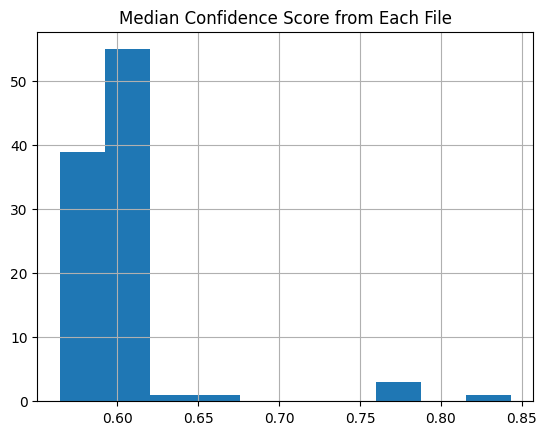

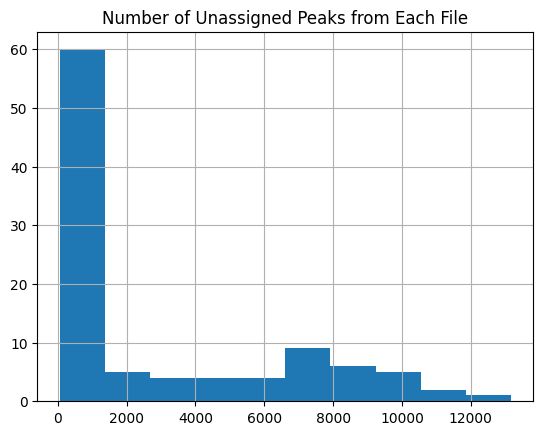

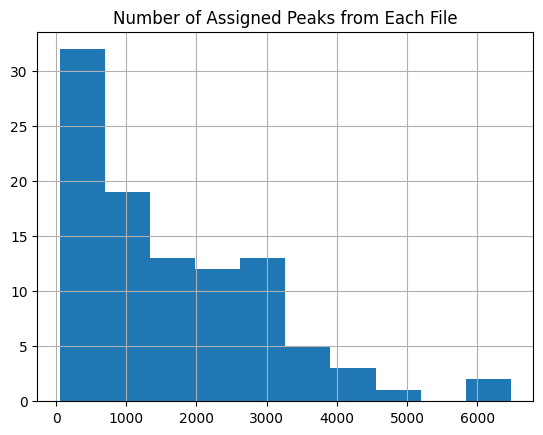

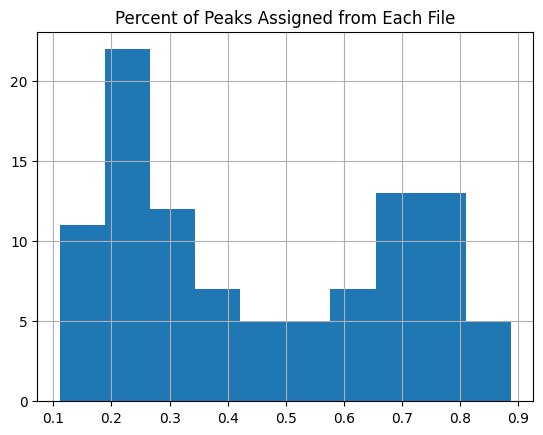

In [168]:
#histograms
qc_summary.hist("median_cs")
plt.title('Median Confidence Score from Each File')
plt.show()

qc_summary.hist("unassigned")
plt.title('Number of Unassigned Peaks from Each File')
plt.show()

qc_summary.hist("assigned")
plt.title('Number of Assigned Peaks from Each File')
plt.show()

qc_summary.hist("assigned_perc")
plt.title('Percent of Peaks Assigned from Each File')
plt.show()


Create heatmap of molecular formulas in each processed NOM data object.

<Axes: xlabel='mol_formulas', ylabel='processed'>

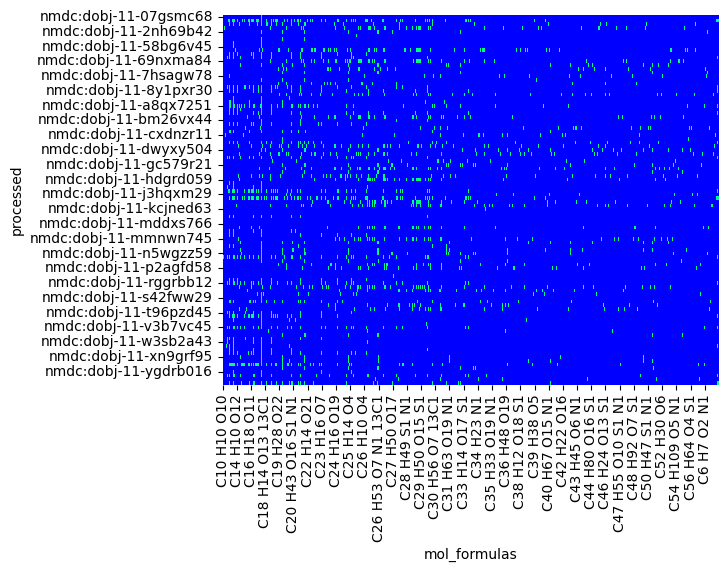

In [169]:
#list all molecular formulas next to the processed nom id in which they were found, dropping nas which came from rows with no molecular formulas matching
formula_nom=qc_summary[['processed','mol_formulas']][:100].explode('mol_formulas').dropna()

#add column indicating presence in that processed nom id
formula_nom['presence']=1

#create presence/absence matrix
formula_matrix=formula_nom.pivot_table('presence', index='processed', columns="mol_formulas").fillna(0).astype(int)

#temporary heatmap (will do more complex one with xarrray later so that sample type can be added in)
sns.heatmap(formula_matrix, vmin=0, vmax=1, cbar=False, cmap="winter")